# Laboration deep learning AI21

## 0. EDA och filhantering

Creating the folders with python :

In [1]:
import os , random, shutil, glob, cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

In [2]:
parent_dir = os.getcwd() #get actual directory
main_folders = ["experiment_small_data","experiment_tiny_data","original_data"]
subfolders = ["experiment_small_data/test","experiment_small_data/train","experiment_small_data/val","experiment_tiny_data/test","experiment_tiny_data/train","experiment_tiny_data/val","original_data/train","original_data/test"]

for main_f in main_folders :
    for sub_f in subfolders : 
        sub_f_list = sub_f.split("/") # turn subfolder path into list of folders
        if main_f in sub_f_list : 
            directory_name = sub_f_list[1] #actual directory to make is the 2nd in the list
            path = os.path.join(parent_dir,main_f,directory_name) #creating the folder path
            if not os.path.isdir(path): # check if path doesn't already exist
                try: 
                    os.makedirs(path) #create all missing folders in the folder path 
                except OSError as error: 
                    print(error)

Read in 10 pictures randomly and plot them out, use the label as plot title :

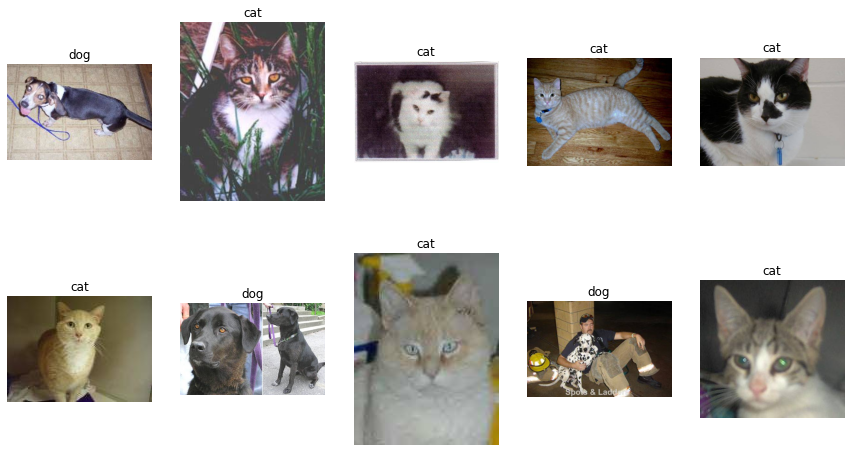

In [3]:
folder = "original_data/train/train" #source folder for all labeled images

files = random.sample(glob.glob(parent_dir+"/"+folder+"/*.jpg"), 10) # getting a random sample of 10 jpg files from directory

fig, axes = plt.subplots(2,5, figsize=(15,8))
for file_path,(i, ax) in zip(files,enumerate(axes.flatten())) : 
    label = file_path.split("/")[-1].split(".")[0] # getting the label from the path
    image = plt.imread(file_path) # read image with plt imread method
    ax.imshow(image) 
    ax.set_title(f"{label}")
    ax.axis("off")


Split the data into train / validation / test :

In [4]:
# splitting the data 

folder_for = lambda x : os.path.join(parent_dir,data,x) #creates folder path
source_folder = os.path.join(parent_dir,"original_data/train/train") # source of all pictures we will use for train|val|test

data_names = ["experiment_small_data","experiment_tiny_data"]
samples_sizes = [(800,200,250),(80,20,25)]

for data,sample_size in zip(data_names,samples_sizes): #loop simultaneously through folder names and samples size
    train_size,val_size, test_size = sample_size # pick the train,val,test sizes

    animal_list = lambda x : [x+"."+str(y)+".jpg" for y in random.sample(range(1,12500),sum(sample_size))] # returns a list of randomly picked files for a specific label
    cats = animal_list("cat") 
    dogs = animal_list("dog") 

    #loop trough our ranges and subfolder names (ex : train will have a range 0:800 or 0:80 depending on tiny or small data)
    for (start,end),trainvaltest in zip([(0,train_size),(train_size,train_size+val_size),(train_size+val_size,len(cats))],["train","val","test"]):
        if len(glob.glob(folder_for(trainvaltest)+"/*.jpg")) == 0: # check if destination folder is empty
            for cat_picture,dog_picture in zip(cats[start:end],dogs[start:end]): # loop through the cats and dogs files list and copy them into destination folder
                shutil.copy(os.path.join(source_folder,cat_picture),folder_for(trainvaltest))
                shutil.copy(os.path.join(source_folder,dog_picture),folder_for(trainvaltest))

        #else : 
        #    print(data,"/",trainvaltest," folder already filled, please empty the folder and try again")

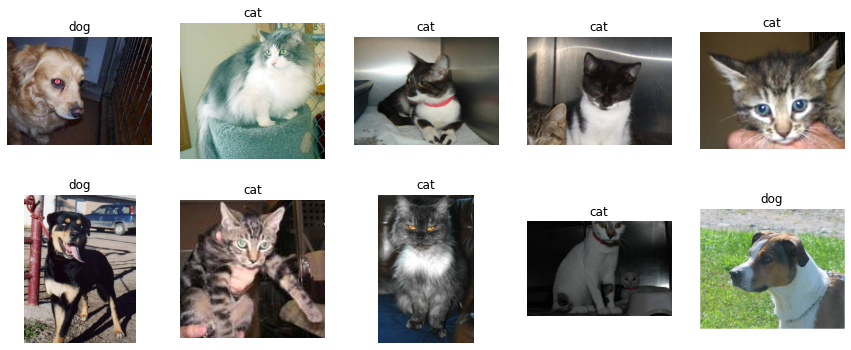

In [5]:
# get a sample of 5 randomly chosen pictures from each of small and tiny data
s_images = random.sample(glob.glob(parent_dir+"/"+"experiment_small_data"+"/train/*.jpg"),5)
t_images = random.sample(glob.glob(parent_dir+"/"+"experiment_tiny_data"+"/val/*.jpg"),5)

fig,ax = plt.subplots(2,5,figsize = (15,6))

#plot 
for path,axe in zip(s_images+t_images,ax.flatten()) : 
    label = path.split("/")[-1].split(".")[0]
    image = plt.imread(path)
    axe.imshow(image)
    axe.set_title(label)
    axe.axis("off")



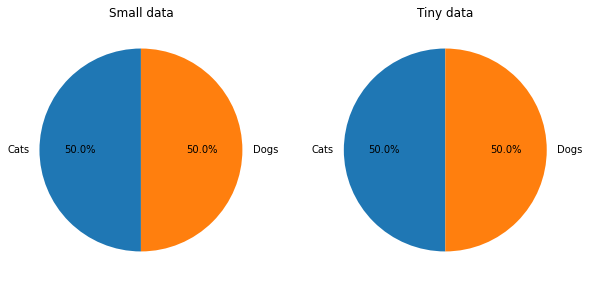

In [6]:
#Checking if the data is well balanced 

def get_proportions(folder_path): # returns a list of 2 values for dogs and cats amounts in folder
        data_dogs = 0
        data_cats = 0
        for file_path in glob.glob(parent_dir+"/"+folder_path+"/train/*.jpg"): # go though all jpg files in directory
                label = file_path.split("/")[-1].split(".")[0] #get label
                if label == "dog" : 
                        data_dogs += 1
                else : 
                        data_cats += 1 
        return [data_cats,data_dogs]

fig, ax = plt.subplots(1,2,figsize=(10,5))

# looping through axes and folder path as well as data name to plot the pie charts
for (folder_path, data_name), axe in zip([("experiment_small_data","Small data"),("experiment_tiny_data","Tiny data")],ax.flatten()):
        axe.pie(get_proportions(folder_path=folder_path), 
                labels=["Cats","Dogs"], 
                startangle=90, 
                autopct='%1.1f%%'
                )
        axe.set_title(data_name)

plt.show()

In [7]:
#creating the dataframes 

label_of = lambda x: x.split("/")[-1].split(".")[0] # return label from file path
small = "experiment_small_data"
tiny = "experiment_tiny_data"

def create_dataframe(folder,subfolder): # returns the dataframe from the images of a subfolder
    #create and shuffle the list of lists of file paths and labels before creating the dataframe
    data = shuffle([[file_path,1 if label_of(file_path)=="dog" else 0] for file_path in glob.glob(os.path.join(parent_dir,folder,subfolder)+"/*.jpg")])
    df = pd.DataFrame(data,columns=["Path","Label"])
    return df

#storing all dataframes in a dictionary
df_dict = {}
for folder in [small,tiny]: 
    for subfolder in ["train","val","test"]: 
        df_dict[f"{folder}_{subfolder}_df"] = create_dataframe(folder,subfolder)

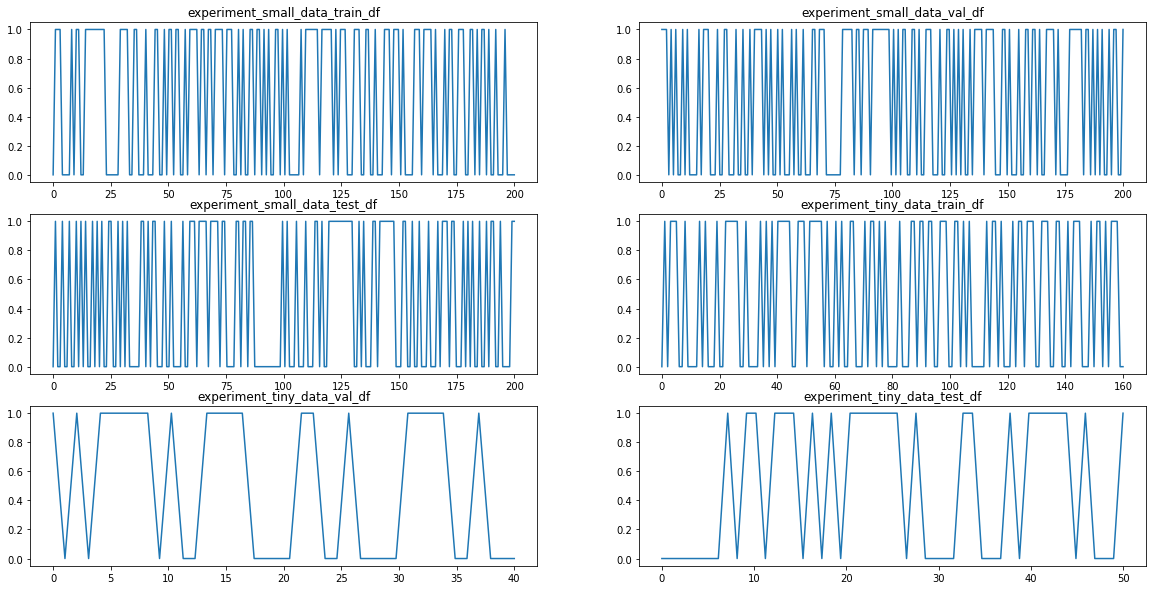

In [8]:
# we will plot the values and see if there is any long horizontal lines that 
# would mean our data is not well shuffled

fig,ax = plt.subplots(3,2,figsize=(20,10))

for key,axis in zip(df_dict,ax.flatten()) : 
    # for better visibily, we will plot a max of 200 points by dataframe
    y = df_dict[key].Label[:min(200,len(df_dict[key]))] 
    x = np.linspace(0,len(y),len(y))
    axis.plot(x,y) 
    axis.set_title(key)

plt.show()

# 1. Bildbehandling

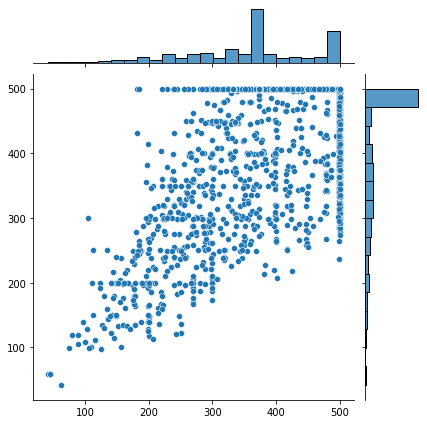

In [9]:
import seaborn as sns

# we will store heights and weights in these lists
widths=[] 
heights=[]

#gather the dimensions from both datasets
for image_path in df_dict["experiment_small_data_train_df"]["Path"] :
    w,h,_ = cv2.imread(image_path).shape
    widths.append(w)
    heights.append(h)

for image_path in df_dict["experiment_tiny_data_train_df"]["Path"] :
    w,h,_ = cv2.imread(image_path).shape
    widths.append(w)
    heights.append(h)

#plot
sns.jointplot(x=widths,y=heights)
plt.show()

We will be resizing all pictures to 200x200 for the following reasons : 
- We want to decrease the size more than we are increasing it since picture tend to lose details when increasing their dimensions
- The majority of the images seem close to the 1:1 ratio 
- That's as low as we can go to keep most of the image quality and save on computing time and power.

We will also let go of any pictures that have one or both dimensions lower than 100px, those images are both too small and too likely to lose any kind of image quality when increased all the way to twice their size or more. 

In [10]:
SIZE = 200

def create_dataset(key):
    """ Takes in the key of the dataframe in our dataframe dictionary 
    returns the dataframe after adding the resized image and 2 columns containing the original
    dimensions of each image"""

    df = df_dict[key] # read the dataframe
    #create empty lists
    images = []
    numbers = []
    heights = [] 
    widths = []

    for img_path in df["Path"]: #loop through images paths
        #add image number and image original size to dataframe
        image_number = img_path.split("/")[-1].split(".")[1] 
        img = cv2.imread(img_path)
        heights.append(img.shape[0])
        widths.append(img.shape[1])
        numbers.append(image_number)
        # resize image and add it to the df
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # switching the coloring code to RGB
        images.append(img)
    
    #add columns to dataframe
    df["Image_number"] = numbers 
    df["Image"] = images
    df["Width"] = widths 
    df["Height"] = heights

    return df 


for key in df_dict : 
    length = len(df_dict[key])
    df_dict[key] = create_dataset(key) 
    #removing the images of original dimensions under 100
    df_dict[key] = df_dict[key][df_dict[key]["Width"]>=100]
    df_dict[key] = df_dict[key][df_dict[key]["Height"]>=100]
    print(f"Removed {length - len(df_dict[key])} rows from {key}")


Removed 10 rows from experiment_small_data_train_df
Removed 7 rows from experiment_small_data_val_df
Removed 4 rows from experiment_small_data_test_df
Removed 1 rows from experiment_tiny_data_train_df
Removed 0 rows from experiment_tiny_data_val_df
Removed 0 rows from experiment_tiny_data_test_df


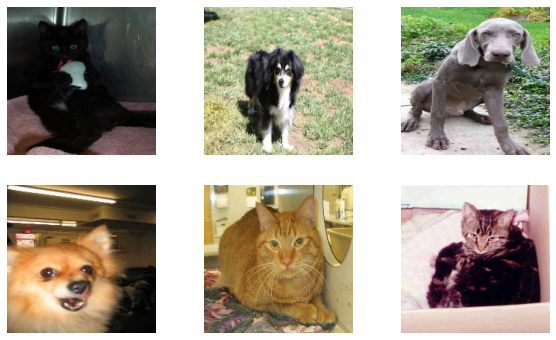

In [12]:
def plot_random_image(df,ax): #plots random image from a dataframe in an axis
    img = df["Image"][random.randint(0,len(df)-1)] 
    ax.imshow(img)
    ax.axis("off")

#plot
fig,ax = plt.subplots(2,3,figsize=(10,6))

for key,axis in zip(df_dict,ax.flatten()): 
    plot_random_image(df_dict[key],axis)

In [13]:
# create the X and Y data 

def create_X_Y_of(key):
    """ 
    Takes in a key from our dataframe dictionary keys
    returns scaled X and Y
    """
    Y = df_dict[key].Label 
    X = np.ones((len(df_dict[key].Image),200,200,3),dtype="float32")
    for i,img in enumerate(df_dict[key].Image):
        img = img.astype("float32")/255   #scaling
        X[i] = img.reshape(200,200,3)
    
    return shuffle(X,Y) 

# we store the X and Y in a new dictionary 
scaled_data_dict = {}
for key in df_dict: 
    name = f"{key.split('_')[1]}_{key.split('_')[-2]}"
    scaled_data_dict[name] = create_X_Y_of(key)

In [14]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AUGMENT_RATIO = 5 # number of images to generate per image

image_generator = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2,
    zoom_range=[0.5,1.0],
    horizontal_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2
)

for key in ["small_train","tiny_train"]: 
    X,Y = scaled_data_dict[key] #get the original X and Y
    augm_X = []
    augm_Y = []

    # creating new images 
    for (ind,img),label in zip(enumerate(X),Y) : 
        x = np.expand_dims(img,0) #resizing the numpy array
        iterator = image_generator.flow(x, batch_size=32) #instanciate the iterator

        for _ in range(AUGMENT_RATIO) : #creating "AUGMENT_RATIO" number of new images
            next_image = np.array(iterator.next()[0]) #get the image
            #append image and label to lists
            augm_X.append(next_image)
            augm_Y.append(label)
    
    #add original data to augmented data
    augm_X+= list(X)
    augm_Y+= list(Y)

    #add augmented data to scaled data dictionary with _augm suffix
    scaled_data_dict[f"{key}_augm"]  = shuffle(np.array(augm_X),np.array(augm_Y))      

    print(f"{key} COMPLETED") #for tracking progress


small_train COMPLETED
tiny_train COMPLETED


In [15]:
#shape checking
X_train_augm, y_train_augm = scaled_data_dict["small_train_augm"]

X_train_augm.shape , y_train_augm.shape

((9540, 200, 200, 3), (9540,))

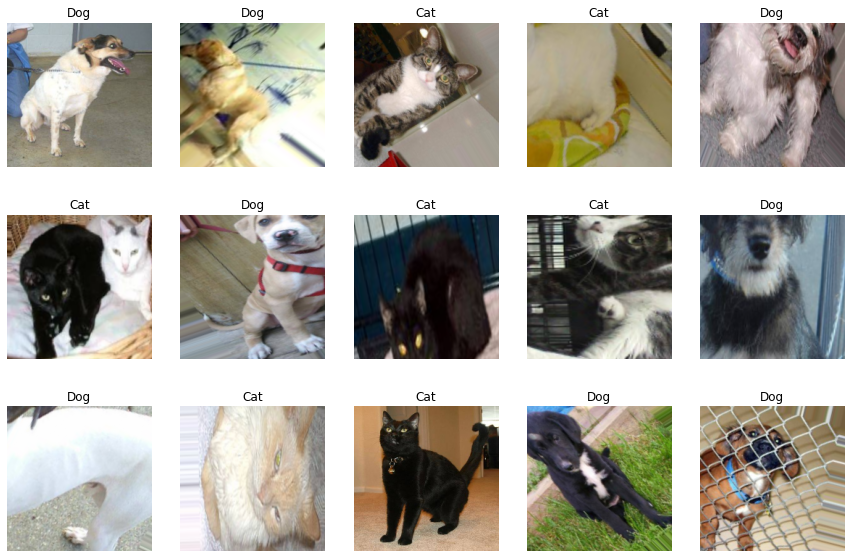

In [16]:
#plotting some images to control quality and labels
fig,ax = plt.subplots(3,5,figsize=(15,10))

for i,axe in enumerate(ax.flatten()): 
    axe.imshow(X_train_augm[i])
    axe.set_title("Dog" if y_train_augm[i]==1 else "Cat") 
    axe.axis("off")

plt.show()

Last we will save the numpy arrays for all datasets to be able to use them on Kaggle for faster computing.

In [26]:
for key in scaled_data_dict: 
    np.save(f"numpy_files/{key}_X.npy", scaled_data_dict[key][0])
    np.save(f"numpy_files/{key}_Y.npy", scaled_data_dict[key][1])

# 2. Training the models 

In [22]:
datasets_keys = ["small_train","small_train_augm","tiny_train","tiny_train_augm"]

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D,Flatten
from tensorflow.keras.optimizers import Adam 

X_train,y_train = scaled_data_dict["small_train"]

def CNN_model(learning_rate=0.001, drop_rate = .5, kernels = [32,64,128,128]): 
    adam = Adam(learning_rate= learning_rate) 

    model = Sequential(name = "CNN_model")

    # the convolutional layers 
    for number_kernel in kernels : 
        conv_layer = Conv2D(number_kernel, kernel_size = (3,3), activation = "relu", kernel_initializer = "he_normal", input_shape = X_train.shape[1:])
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size= (2,2), strides = 2))

    # MLP layers 
    model.add(Flatten()) 
    model.add(Dropout(drop_rate)) 
    model.add(Dense(512, activation = "relu", kernel_initializer = "he_normal")) 
    model.add(Dense(1,activation="sigmoid"))

    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=["accuracy"]) 

    return model 

In [23]:
#training on small training data
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm 

dropout_rates = np.arange(0.1,0.6,0.1)
X_train,y_train = scaled_data_dict["small_train"]
early_stopper = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

do_acc = {}
for do_rate in tqdm(dropout_rates):
    do_rate = np.round(do_rate,1)
    model = CNN_model(drop_rate=do_rate)
    model.fit(
        X_train, 
        y_train, 
        epochs = 20, 
        callbacks = [early_stopper],
        validation_split = 1/5
    )
    metrics = pd.DataFrame(model.history.history)
    do_acc[do_rate] = metrics["val_accuracy"].iloc[-1]



  0%|          | 0/5 [00:00<?, ?it/s]2022-05-07 16:05:49.953779: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
40/40 [==============================] - 145s 3s/step - loss: 1.3360 - accuracy: 0.5110 - val_loss: 0.6898 - val_accuracy: 0.5283
Epoch 2/20
40/40 [==============================] - 99s 2s/step - loss: 0.6818 - accuracy: 0.5425 - val_loss: 0.6796 - val_accuracy: 0.5472
Epoch 3/20
40/40 [==============================] - 106s 3s/step - loss: 0.6507 - accuracy: 0.6234 - val_loss: 0.7065 - val_accuracy: 0.5881
Epoch 4/20
40/40 [==============================] - 156s 4s/step - loss: 0.6113 - accuracy: 0.6541 - val_loss: 0.6905 - val_accuracy: 0.5943
Epoch 5/20
40/40 [==============================] - 156s 4s/step - loss: 0.5613 - accuracy: 0.6950 - val_loss: 0.6613 - val_accuracy: 0.6164
Epoch 6/20
40/40 [==============================] - 151s 4s/step - loss: 0.4934 - accuracy: 0.7429 - val_loss: 0.6835 - val_accuracy: 0.6101
Epoch 7/20
40/40 [==============================] - 153s 4s/step - loss: 0.4515 - accuracy: 0.7822 - val_loss: 0.7352 - val_accuracy: 0.5881
Epoch 8/20
40/

 20%|██        | 1/5 [23:51<1:35:25, 1431.47s/it]

Epoch 1/20
40/40 [==============================] - 119s 3s/step - loss: 1.9049 - accuracy: 0.5016 - val_loss: 0.6933 - val_accuracy: 0.4906
Epoch 2/20
40/40 [==============================] - 80s 2s/step - loss: 0.6897 - accuracy: 0.5464 - val_loss: 0.6891 - val_accuracy: 0.5126
Epoch 3/20
40/40 [==============================] - 77s 2s/step - loss: 0.6864 - accuracy: 0.5409 - val_loss: 0.6826 - val_accuracy: 0.5629
Epoch 4/20
40/40 [==============================] - 79s 2s/step - loss: 0.6632 - accuracy: 0.5967 - val_loss: 0.6796 - val_accuracy: 0.5472
Epoch 5/20
40/40 [==============================] - 80s 2s/step - loss: 0.6710 - accuracy: 0.5770 - val_loss: 0.7166 - val_accuracy: 0.5566
Epoch 6/20
40/40 [==============================] - 80s 2s/step - loss: 0.6259 - accuracy: 0.6305 - val_loss: 0.6988 - val_accuracy: 0.5440
Epoch 7/20
40/40 [==============================] - 79s 2s/step - loss: 0.5748 - accuracy: 0.6808 - val_loss: 0.7216 - val_accuracy: 0.5849
Epoch 8/20
40/40 [=

 40%|████      | 2/5 [37:06<52:51, 1057.05s/it]  

Epoch 1/20
40/40 [==============================] - 82s 2s/step - loss: 1.7658 - accuracy: 0.5094 - val_loss: 0.6948 - val_accuracy: 0.4937
Epoch 2/20
40/40 [==============================] - 79s 2s/step - loss: 0.6821 - accuracy: 0.5684 - val_loss: 0.6760 - val_accuracy: 0.5440
Epoch 3/20
40/40 [==============================] - 79s 2s/step - loss: 0.6668 - accuracy: 0.5936 - val_loss: 0.6509 - val_accuracy: 0.5912
Epoch 4/20
40/40 [==============================] - 78s 2s/step - loss: 0.6673 - accuracy: 0.6038 - val_loss: 0.6573 - val_accuracy: 0.6132
Epoch 5/20
40/40 [==============================] - 78s 2s/step - loss: 0.6320 - accuracy: 0.6289 - val_loss: 0.6993 - val_accuracy: 0.6384
Epoch 6/20
40/40 [==============================] - 80s 2s/step - loss: 0.6140 - accuracy: 0.6439 - val_loss: 0.7171 - val_accuracy: 0.5597
Epoch 7/20
40/40 [==============================] - 79s 2s/step - loss: 0.5797 - accuracy: 0.6816 - val_loss: 0.6714 - val_accuracy: 0.6101
Epoch 8/20
40/40 [==

 60%|██████    | 3/5 [47:45<28:51, 865.99s/it] 

Epoch 1/20
40/40 [==============================] - 99s 2s/step - loss: 1.4081 - accuracy: 0.5275 - val_loss: 0.6945 - val_accuracy: 0.4811
Epoch 2/20
40/40 [==============================] - 92s 2s/step - loss: 0.6851 - accuracy: 0.5566 - val_loss: 0.6914 - val_accuracy: 0.5094
Epoch 3/20
40/40 [==============================] - 91s 2s/step - loss: 0.6765 - accuracy: 0.5888 - val_loss: 0.6847 - val_accuracy: 0.5566
Epoch 4/20
40/40 [==============================] - 92s 2s/step - loss: 0.6459 - accuracy: 0.6132 - val_loss: 0.6860 - val_accuracy: 0.5503
Epoch 5/20
40/40 [==============================] - 91s 2s/step - loss: 0.6301 - accuracy: 0.6454 - val_loss: 0.6838 - val_accuracy: 0.5786
Epoch 6/20
40/40 [==============================] - 89s 2s/step - loss: 0.6077 - accuracy: 0.6667 - val_loss: 0.6752 - val_accuracy: 0.6101
Epoch 7/20
40/40 [==============================] - 92s 2s/step - loss: 0.5598 - accuracy: 0.6958 - val_loss: 0.7225 - val_accuracy: 0.5503
Epoch 8/20
40/40 [==

 80%|████████  | 4/5 [1:04:22<15:17, 917.92s/it]

Epoch 1/20
40/40 [==============================] - 93s 2s/step - loss: 1.0912 - accuracy: 0.5173 - val_loss: 0.6874 - val_accuracy: 0.5283
Epoch 2/20
40/40 [==============================] - 92s 2s/step - loss: 0.6909 - accuracy: 0.5385 - val_loss: 0.8433 - val_accuracy: 0.5126
Epoch 3/20
40/40 [==============================] - 92s 2s/step - loss: 0.6924 - accuracy: 0.5330 - val_loss: 0.6761 - val_accuracy: 0.5535
Epoch 4/20
40/40 [==============================] - 95s 2s/step - loss: 0.6711 - accuracy: 0.5825 - val_loss: 0.7015 - val_accuracy: 0.5094
Epoch 5/20
40/40 [==============================] - 92s 2s/step - loss: 0.6698 - accuracy: 0.5778 - val_loss: 0.6837 - val_accuracy: 0.5660
Epoch 6/20
40/40 [==============================] - 92s 2s/step - loss: 0.6448 - accuracy: 0.6258 - val_loss: 0.6782 - val_accuracy: 0.5566
Epoch 7/20
40/40 [==============================] - 93s 2s/step - loss: 0.6278 - accuracy: 0.6376 - val_loss: 0.6829 - val_accuracy: 0.5597
Epoch 8/20
40/40 [==

100%|██████████| 5/5 [1:30:09<00:00, 1081.96s/it]


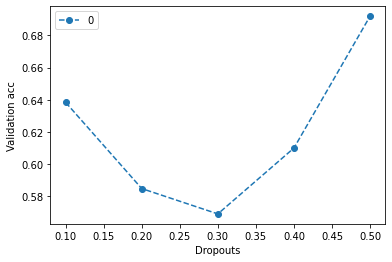

In [25]:
pd.DataFrame(do_acc.values(), index=do_acc.keys()).plot(
    xlabel="Dropouts", ylabel="Validation acc", style="--o")

plt.show()

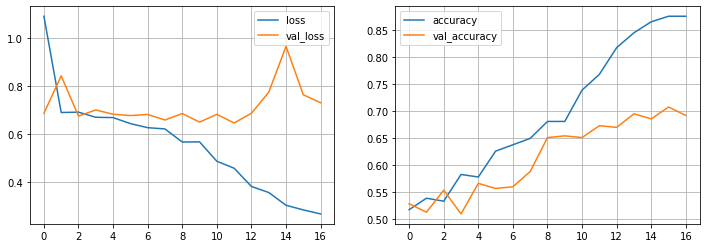

In [27]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], grid = True)
    metrics[["accuracy", "val_accuracy"]].plot(ax = ax[1], grid = True)

metrics = pd.DataFrame(model.history.history)
plot_metrics(metrics)

In [28]:
#training on small training data
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm 

dropout_rates = np.arange(0.1,0.6,0.1)
X_train,y_train = scaled_data_dict["small_train_augm"]
early_stopper = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

do_acc = {}
for do_rate in tqdm(dropout_rates):
    do_rate = np.round(do_rate,1)
    model = CNN_model(drop_rate=do_rate)
    model.fit(
        X_train, 
        y_train, 
        epochs = 20, 
        callbacks = [early_stopper],
        validation_split = 1/5
    )
    metrics = pd.DataFrame(model.history.history)
    do_acc[do_rate] = metrics["val_accuracy"].iloc[-1]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20
239/239 [==============================] - 864s 4s/step - loss: 0.7768 - accuracy: 0.5094 - val_loss: 0.6913 - val_accuracy: 0.5115
Epoch 2/20
239/239 [==============================] - 754s 3s/step - loss: 0.6978 - accuracy: 0.5273 - val_loss: 0.6827 - val_accuracy: 0.5388
Epoch 3/20
239/239 [==============================] - 686s 3s/step - loss: 0.6819 - accuracy: 0.5508 - val_loss: 0.6806 - val_accuracy: 0.5498
Epoch 4/20
239/239 [==============================] - 689s 3s/step - loss: 0.6717 - accuracy: 0.5697 - val_loss: 0.6901 - val_accuracy: 0.5582
Epoch 5/20
239/239 [==============================] - 723s 3s/step - loss: 0.6639 - accuracy: 0.5831 - val_loss: 0.6576 - val_accuracy: 0.5938
Epoch 6/20
239/239 [==============================] - 694s 3s/step - loss: 0.6335 - accuracy: 0.6305 - val_loss: 0.6563 - val_accuracy: 0.6169
Epoch 7/20
239/239 [==============================] - 705s 3s/step - loss: 0.6099 - accuracy: 0.6579 - val_loss: 0.6448 - val_accuracy: 0.6336

 20%|██        | 1/5 [2:29:19<9:57:16, 8959.09s/it]

Epoch 1/20
239/239 [==============================] - 791s 3s/step - loss: 0.7703 - accuracy: 0.5229 - val_loss: 0.6886 - val_accuracy: 0.5440
Epoch 2/20
239/239 [==============================] - 791s 3s/step - loss: 0.6623 - accuracy: 0.5802 - val_loss: 0.6610 - val_accuracy: 0.5970
Epoch 3/20
239/239 [==============================] - 773s 3s/step - loss: 0.6490 - accuracy: 0.6017 - val_loss: 0.6426 - val_accuracy: 0.6190
Epoch 4/20
239/239 [==============================] - 755s 3s/step - loss: 0.6335 - accuracy: 0.6292 - val_loss: 0.6273 - val_accuracy: 0.6211
Epoch 5/20
239/239 [==============================] - 763s 3s/step - loss: 0.5952 - accuracy: 0.6695 - val_loss: 0.6280 - val_accuracy: 0.6677
Epoch 6/20
239/239 [==============================] - 770s 3s/step - loss: 0.5524 - accuracy: 0.7074 - val_loss: 0.6072 - val_accuracy: 0.6813
Epoch 7/20
239/239 [==============================] - 764s 3s/step - loss: 0.5155 - accuracy: 0.7370 - val_loss: 0.6200 - val_accuracy: 0.6677

 40%|████      | 2/5 [4:53:04<7:18:08, 8762.80s/it]

Epoch 1/20
239/239 [==============================] - 769s 3s/step - loss: 0.8259 - accuracy: 0.5545 - val_loss: 0.6584 - val_accuracy: 0.6300
Epoch 2/20
239/239 [==============================] - 762s 3s/step - loss: 0.6466 - accuracy: 0.6174 - val_loss: 0.6418 - val_accuracy: 0.6200
Epoch 3/20
239/239 [==============================] - 764s 3s/step - loss: 0.6252 - accuracy: 0.6485 - val_loss: 0.6257 - val_accuracy: 0.6326
Epoch 4/20
239/239 [==============================] - 768s 3s/step - loss: 0.5918 - accuracy: 0.6806 - val_loss: 0.6325 - val_accuracy: 0.6599
Epoch 5/20
239/239 [==============================] - 797s 3s/step - loss: 0.5636 - accuracy: 0.7026 - val_loss: 0.5888 - val_accuracy: 0.6897
Epoch 6/20
239/239 [==============================] - 788s 3s/step - loss: 0.5443 - accuracy: 0.7189 - val_loss: 0.5845 - val_accuracy: 0.7028
Epoch 7/20
239/239 [==============================] - 786s 3s/step - loss: 0.5134 - accuracy: 0.7360 - val_loss: 0.5743 - val_accuracy: 0.7055

 60%|██████    | 3/5 [7:30:00<5:02:01, 9060.98s/it]

Epoch 1/20
239/239 [==============================] - 781s 3s/step - loss: 0.7514 - accuracy: 0.5523 - val_loss: 0.6679 - val_accuracy: 0.5755
Epoch 2/20
239/239 [==============================] - 772s 3s/step - loss: 0.6546 - accuracy: 0.6065 - val_loss: 0.6852 - val_accuracy: 0.5618
Epoch 3/20
239/239 [==============================] - 778s 3s/step - loss: 0.6300 - accuracy: 0.6342 - val_loss: 0.6306 - val_accuracy: 0.6462
Epoch 4/20
239/239 [==============================] - 765s 3s/step - loss: 0.6042 - accuracy: 0.6718 - val_loss: 0.6153 - val_accuracy: 0.6688
Epoch 5/20
239/239 [==============================] - 775s 3s/step - loss: 0.5820 - accuracy: 0.6895 - val_loss: 0.6057 - val_accuracy: 0.6834
Epoch 6/20
239/239 [==============================] - 775s 3s/step - loss: 0.5508 - accuracy: 0.7153 - val_loss: 0.5919 - val_accuracy: 0.6876
Epoch 7/20
239/239 [==============================] - 768s 3s/step - loss: 0.5213 - accuracy: 0.7398 - val_loss: 0.5937 - val_accuracy: 0.7007

 80%|████████  | 4/5 [10:22:38<2:39:32, 9572.98s/it]

Epoch 1/20
239/239 [==============================] - 779s 3s/step - loss: 0.7450 - accuracy: 0.5110 - val_loss: 0.6894 - val_accuracy: 0.5215
Epoch 2/20
239/239 [==============================] - 901s 4s/step - loss: 0.6885 - accuracy: 0.5317 - val_loss: 0.6879 - val_accuracy: 0.5225
Epoch 3/20
239/239 [==============================] - 864s 4s/step - loss: 0.6923 - accuracy: 0.5436 - val_loss: 0.6958 - val_accuracy: 0.5110
Epoch 4/20
239/239 [==============================] - 871s 4s/step - loss: 0.6834 - accuracy: 0.5464 - val_loss: 0.6829 - val_accuracy: 0.5404
Epoch 5/20
239/239 [==============================] - 950s 4s/step - loss: 0.6774 - accuracy: 0.5546 - val_loss: 0.6821 - val_accuracy: 0.5404
Epoch 6/20
239/239 [==============================] - 802s 3s/step - loss: 0.6755 - accuracy: 0.5599 - val_loss: 0.6815 - val_accuracy: 0.5508
Epoch 7/20
239/239 [==============================] - 747s 3s/step - loss: 0.6694 - accuracy: 0.5710 - val_loss: 0.7029 - val_accuracy: 0.5524

100%|██████████| 5/5 [13:20:02<00:00, 9600.48s/it]


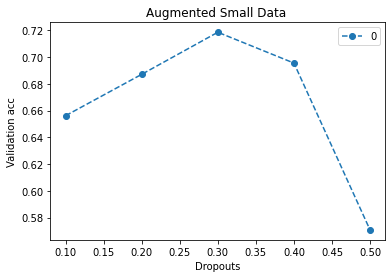

In [38]:
pd.DataFrame(do_acc.values(), index=do_acc.keys()).plot(
    xlabel="Dropouts", ylabel="Validation acc", style="--o")
plt.title("Augmented Small Data ")
plt.show()

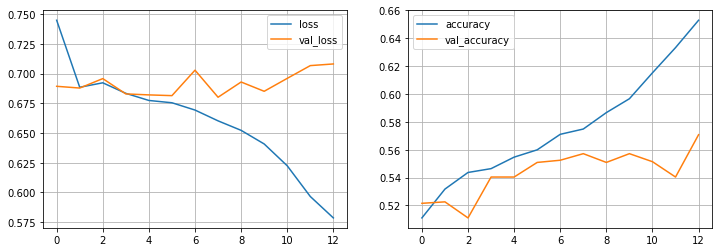

In [30]:
metrics = pd.DataFrame(model.history.history)
plot_metrics(metrics)

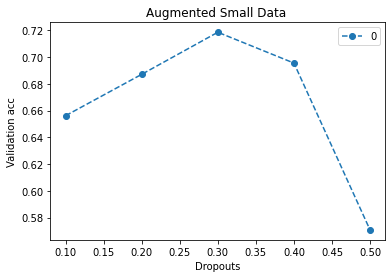

In [37]:
pd.DataFrame(do_acc.values(), index=do_acc.keys()).plot(
    xlabel="Dropouts", ylabel="Validation acc", style="--o")

plt.title("Augmented Small Data ")
plt.show()

In [39]:
#training on tiny training data
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm 

dropout_rates = np.arange(0.1,0.6,0.1)
X_train,y_train = scaled_data_dict["tiny_train"]
early_stopper = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

do_acc = {}
for do_rate in tqdm(dropout_rates):
    do_rate = np.round(do_rate,1)
    model = CNN_model(drop_rate=do_rate)
    model.fit(
        X_train, 
        y_train, 
        epochs = 20, 
        callbacks = [early_stopper],
        validation_split = 1/5
    )
    metrics = pd.DataFrame(model.history.history)
    do_acc[do_rate] = metrics["val_accuracy"].iloc[-1]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20
4/4 [==============================] - 19s 4s/step - loss: 9.6069 - accuracy: 0.4567 - val_loss: 1.0539 - val_accuracy: 0.3750
Epoch 2/20
4/4 [==============================] - 17s 4s/step - loss: 0.7772 - accuracy: 0.4567 - val_loss: 0.6767 - val_accuracy: 0.5312
Epoch 3/20
4/4 [==============================] - 13s 3s/step - loss: 0.6608 - accuracy: 0.6299 - val_loss: 0.6728 - val_accuracy: 0.7188
Epoch 4/20
4/4 [==============================] - 15s 4s/step - loss: 0.6221 - accuracy: 0.6929 - val_loss: 0.6078 - val_accuracy: 0.6875
Epoch 5/20
4/4 [==============================] - 17s 5s/step - loss: 0.5559 - accuracy: 0.7323 - val_loss: 0.6313 - val_accuracy: 0.6875
Epoch 6/20
4/4 [==============================] - 18s 5s/step - loss: 0.4951 - accuracy: 0.7402 - val_loss: 0.5635 - val_accuracy: 0.6875
Epoch 7/20
4/4 [==============================] - 17s 4s/step - loss: 0.4284 - accuracy: 0.7953 - val_loss: 0.6584 - val_accuracy: 0.6250
Epoch 8/20
4/4 [==================

 20%|██        | 1/5 [02:56<11:45, 176.34s/it]

Epoch 1/20
4/4 [==============================] - 14s 3s/step - loss: 4.5456 - accuracy: 0.4803 - val_loss: 0.9441 - val_accuracy: 0.3750
Epoch 2/20
4/4 [==============================] - 12s 3s/step - loss: 0.7160 - accuracy: 0.5354 - val_loss: 0.6418 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 15s 4s/step - loss: 0.7006 - accuracy: 0.4961 - val_loss: 0.7335 - val_accuracy: 0.3750
Epoch 4/20
4/4 [==============================] - 14s 4s/step - loss: 0.6705 - accuracy: 0.6772 - val_loss: 0.6673 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 13s 3s/step - loss: 0.6552 - accuracy: 0.6772 - val_loss: 0.6387 - val_accuracy: 0.6562
Epoch 6/20
4/4 [==============================] - 14s 4s/step - loss: 0.6001 - accuracy: 0.7165 - val_loss: 0.7429 - val_accuracy: 0.5000
Epoch 7/20
4/4 [==============================] - 11s 3s/step - loss: 0.5796 - accuracy: 0.7087 - val_loss: 0.7987 - val_accuracy: 0.5000
Epoch 8/20
4/4 [==================

 40%|████      | 2/5 [06:47<10:26, 208.88s/it]

Epoch 1/20
4/4 [==============================] - 15s 4s/step - loss: 5.3048 - accuracy: 0.5748 - val_loss: 1.5057 - val_accuracy: 0.3750
Epoch 2/20
4/4 [==============================] - 13s 3s/step - loss: 0.7138 - accuracy: 0.6220 - val_loss: 0.7159 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 12s 3s/step - loss: 0.7620 - accuracy: 0.5039 - val_loss: 0.7275 - val_accuracy: 0.3750
Epoch 4/20
4/4 [==============================] - 12s 3s/step - loss: 0.6671 - accuracy: 0.6142 - val_loss: 0.6647 - val_accuracy: 0.6875
Epoch 5/20
4/4 [==============================] - 11s 3s/step - loss: 0.6531 - accuracy: 0.6614 - val_loss: 0.6635 - val_accuracy: 0.5938
Epoch 6/20
4/4 [==============================] - 12s 3s/step - loss: 0.6758 - accuracy: 0.6142 - val_loss: 0.8495 - val_accuracy: 0.3750
Epoch 7/20
4/4 [==============================] - 12s 3s/step - loss: 0.6415 - accuracy: 0.5669 - val_loss: 0.7397 - val_accuracy: 0.3750
Epoch 8/20
4/4 [==================

 60%|██████    | 3/5 [09:40<06:24, 192.13s/it]

Epoch 1/20
4/4 [==============================] - 17s 4s/step - loss: 10.5624 - accuracy: 0.5039 - val_loss: 0.8133 - val_accuracy: 0.6250
Epoch 2/20
4/4 [==============================] - 13s 3s/step - loss: 0.8181 - accuracy: 0.4961 - val_loss: 0.6633 - val_accuracy: 0.6562
Epoch 3/20
4/4 [==============================] - 13s 3s/step - loss: 0.8033 - accuracy: 0.5354 - val_loss: 0.8654 - val_accuracy: 0.3750
Epoch 4/20
4/4 [==============================] - 12s 3s/step - loss: 0.7159 - accuracy: 0.5591 - val_loss: 0.7509 - val_accuracy: 0.3750
Epoch 5/20
4/4 [==============================] - 12s 3s/step - loss: 0.6486 - accuracy: 0.6614 - val_loss: 0.6494 - val_accuracy: 0.7188
Epoch 6/20
4/4 [==============================] - 12s 3s/step - loss: 0.6363 - accuracy: 0.6772 - val_loss: 0.6598 - val_accuracy: 0.5625
Epoch 7/20
4/4 [==============================] - 12s 3s/step - loss: 0.4989 - accuracy: 0.7638 - val_loss: 0.7910 - val_accuracy: 0.4062
Epoch 8/20
4/4 [=================

 80%|████████  | 4/5 [12:26<03:02, 182.08s/it]

Epoch 1/20
4/4 [==============================] - 13s 3s/step - loss: 7.4685 - accuracy: 0.4803 - val_loss: 0.8438 - val_accuracy: 0.3750
Epoch 2/20
4/4 [==============================] - 13s 3s/step - loss: 0.7620 - accuracy: 0.4882 - val_loss: 0.8103 - val_accuracy: 0.3750
Epoch 3/20
4/4 [==============================] - 13s 3s/step - loss: 0.6781 - accuracy: 0.5354 - val_loss: 0.7521 - val_accuracy: 0.3750
Epoch 4/20
4/4 [==============================] - 12s 3s/step - loss: 0.5971 - accuracy: 0.6772 - val_loss: 0.7447 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 13s 3s/step - loss: 0.7800 - accuracy: 0.5276 - val_loss: 0.6370 - val_accuracy: 0.6562
Epoch 6/20
4/4 [==============================] - 12s 3s/step - loss: 0.5921 - accuracy: 0.6614 - val_loss: 0.6434 - val_accuracy: 0.7812
Epoch 7/20
4/4 [==============================] - 12s 3s/step - loss: 0.5242 - accuracy: 0.7480 - val_loss: 0.6037 - val_accuracy: 0.7188
Epoch 8/20
4/4 [==================

100%|██████████| 5/5 [15:19<00:00, 183.85s/it]


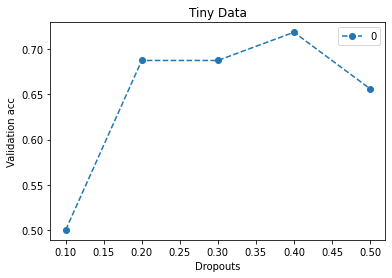

In [40]:
pd.DataFrame(do_acc.values(), index=do_acc.keys()).plot(
    xlabel="Dropouts", ylabel="Validation acc", style="--o")
plt.title("Tiny Data")
plt.show()

In [41]:
#training on tiny augmented training data
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm 

dropout_rates = np.arange(0.1,0.6,0.1)
X_train,y_train = scaled_data_dict["tiny_train_augm"]
early_stopper = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

do_acc = {}
for do_rate in tqdm(dropout_rates):
    do_rate = np.round(do_rate,1)
    model = CNN_model(drop_rate=do_rate)
    model.fit(
        X_train, 
        y_train, 
        epochs = 20, 
        callbacks = [early_stopper],
        validation_split = 1/5
    )
    metrics = pd.DataFrame(model.history.history)
    do_acc[do_rate] = metrics["val_accuracy"].iloc[-1]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20
24/24 [==============================] - 76s 3s/step - loss: 1.2575 - accuracy: 0.5269 - val_loss: 0.6851 - val_accuracy: 0.5550
Epoch 2/20
24/24 [==============================] - 96s 4s/step - loss: 0.6902 - accuracy: 0.5242 - val_loss: 0.6783 - val_accuracy: 0.5393
Epoch 3/20
24/24 [==============================] - 80s 3s/step - loss: 0.6727 - accuracy: 0.5701 - val_loss: 0.6896 - val_accuracy: 0.4607
Epoch 4/20
24/24 [==============================] - 85s 4s/step - loss: 0.6258 - accuracy: 0.6461 - val_loss: 0.6246 - val_accuracy: 0.6335
Epoch 5/20
24/24 [==============================] - 82s 3s/step - loss: 0.5945 - accuracy: 0.6750 - val_loss: 0.6753 - val_accuracy: 0.5445
Epoch 6/20
24/24 [==============================] - 81s 3s/step - loss: 0.5395 - accuracy: 0.7248 - val_loss: 0.6679 - val_accuracy: 0.6178
Epoch 7/20
24/24 [==============================] - 78s 3s/step - loss: 0.4652 - accuracy: 0.7615 - val_loss: 0.7139 - val_accuracy: 0.6649
Epoch 8/20
24/24 [==

 20%|██        | 1/5 [12:16<49:05, 736.37s/it]

Epoch 1/20
24/24 [==============================] - 75s 3s/step - loss: 2.0179 - accuracy: 0.4679 - val_loss: 0.6950 - val_accuracy: 0.4450
Epoch 2/20
24/24 [==============================] - 75s 3s/step - loss: 0.6878 - accuracy: 0.5374 - val_loss: 0.6894 - val_accuracy: 0.6021
Epoch 3/20
24/24 [==============================] - 75s 3s/step - loss: 0.6845 - accuracy: 0.5557 - val_loss: 0.6601 - val_accuracy: 0.6440
Epoch 4/20
24/24 [==============================] - 75s 3s/step - loss: 0.6664 - accuracy: 0.5649 - val_loss: 0.6882 - val_accuracy: 0.5236
Epoch 5/20
24/24 [==============================] - 87s 4s/step - loss: 0.6281 - accuracy: 0.6448 - val_loss: 0.6622 - val_accuracy: 0.5916
Epoch 6/20
24/24 [==============================] - 82s 3s/step - loss: 0.5633 - accuracy: 0.6723 - val_loss: 0.7384 - val_accuracy: 0.6283
Epoch 7/20
24/24 [==============================] - 78s 3s/step - loss: 0.5208 - accuracy: 0.7195 - val_loss: 0.6738 - val_accuracy: 0.5759
Epoch 8/20
24/24 [==

 40%|████      | 2/5 [22:46<33:40, 673.59s/it]

Epoch 1/20
24/24 [==============================] - 70s 3s/step - loss: 1.3947 - accuracy: 0.5164 - val_loss: 0.6929 - val_accuracy: 0.4921
Epoch 2/20
24/24 [==============================] - 75s 3s/step - loss: 0.6947 - accuracy: 0.5111 - val_loss: 0.6841 - val_accuracy: 0.6073
Epoch 3/20
24/24 [==============================] - 65s 3s/step - loss: 0.6798 - accuracy: 0.5976 - val_loss: 0.6871 - val_accuracy: 0.5550
Epoch 4/20
24/24 [==============================] - 70s 3s/step - loss: 0.6680 - accuracy: 0.6121 - val_loss: 0.6963 - val_accuracy: 0.4974
Epoch 5/20
24/24 [==============================] - 70s 3s/step - loss: 0.6706 - accuracy: 0.5727 - val_loss: 0.6546 - val_accuracy: 0.5707
Epoch 6/20
24/24 [==============================] - 70s 3s/step - loss: 0.6506 - accuracy: 0.5793 - val_loss: 0.6735 - val_accuracy: 0.5812
Epoch 7/20
24/24 [==============================] - 68s 3s/step - loss: 0.6368 - accuracy: 0.6265 - val_loss: 0.7149 - val_accuracy: 0.4869
Epoch 8/20
24/24 [==

 60%|██████    | 3/5 [34:24<22:50, 685.12s/it]

Epoch 1/20
24/24 [==============================] - 75s 3s/step - loss: 2.2974 - accuracy: 0.4915 - val_loss: 0.6835 - val_accuracy: 0.5550
Epoch 2/20
24/24 [==============================] - 70s 3s/step - loss: 0.6929 - accuracy: 0.4889 - val_loss: 0.6920 - val_accuracy: 0.5707
Epoch 3/20
24/24 [==============================] - 68s 3s/step - loss: 0.6904 - accuracy: 0.5465 - val_loss: 0.7037 - val_accuracy: 0.4555
Epoch 4/20
24/24 [==============================] - 67s 3s/step - loss: 0.6877 - accuracy: 0.5465 - val_loss: 0.6677 - val_accuracy: 0.5602
Epoch 5/20
24/24 [==============================] - 69s 3s/step - loss: 0.6706 - accuracy: 0.5990 - val_loss: 0.6894 - val_accuracy: 0.5288
Epoch 6/20
24/24 [==============================] - 67s 3s/step - loss: 0.6473 - accuracy: 0.6134 - val_loss: 0.8463 - val_accuracy: 0.5131
Epoch 7/20
24/24 [==============================] - 68s 3s/step - loss: 0.6247 - accuracy: 0.6579 - val_loss: 0.6477 - val_accuracy: 0.5759
Epoch 8/20
24/24 [==

 80%|████████  | 4/5 [49:17<12:46, 766.87s/it]

Epoch 1/20
24/24 [==============================] - 71s 3s/step - loss: 2.1591 - accuracy: 0.4954 - val_loss: 0.6779 - val_accuracy: 0.5550
Epoch 2/20
24/24 [==============================] - 65s 3s/step - loss: 0.6930 - accuracy: 0.5098 - val_loss: 0.6770 - val_accuracy: 0.5550
Epoch 3/20
24/24 [==============================] - 69s 3s/step - loss: 0.6769 - accuracy: 0.5505 - val_loss: 0.6582 - val_accuracy: 0.6073
Epoch 4/20
24/24 [==============================] - 65s 3s/step - loss: 0.6846 - accuracy: 0.5649 - val_loss: 0.6744 - val_accuracy: 0.6545
Epoch 5/20
24/24 [==============================] - 83s 3s/step - loss: 0.6546 - accuracy: 0.6107 - val_loss: 0.6508 - val_accuracy: 0.5759
Epoch 6/20
24/24 [==============================] - 68s 3s/step - loss: 0.6133 - accuracy: 0.6501 - val_loss: 0.6342 - val_accuracy: 0.6021
Epoch 7/20
24/24 [==============================] - 72s 3s/step - loss: 0.6164 - accuracy: 0.6448 - val_loss: 0.6574 - val_accuracy: 0.6335
Epoch 8/20
24/24 [==

100%|██████████| 5/5 [1:02:40<00:00, 752.11s/it]


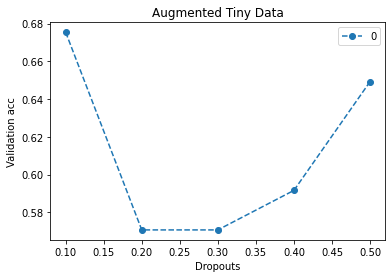

In [42]:
pd.DataFrame(do_acc.values(), index=do_acc.keys()).plot(
    xlabel="Dropouts", ylabel="Validation acc", style="--o")
plt.title("Augmented Tiny Data")
plt.show()

From the tests above we know that the best dropout rate for the non-augmented data was 0.5, the best drop out rate for the augmented data on the other hand was 0.3. 

We will now train our models with those parameters and save the weights so we can compare the models later. 

We will also train the tiny data models. Note that we ran the small data models separatly because they are relatively bigger and therefore were supposed to take a big amount of time to train on the local machine. ( 48000s to train the augmented data models for hyperparameter tuning )

In [85]:
# hyperparameter tuning for small data 
results =[]
results_list= []

for ds in tqdm(["small_train","small_train_augm"]):
    for learning_rate in tqdm([0.001,0.01,0.1]): 
        for kernels in tqdm([[32,64,128,128],[32,64,128],[32,64]]):
            n_layers = len(kernels)
            X_train, y_train = scaled_data_dict[ds]
            drop_rate = 0.5 if ds == "small_train" else 0.3 
            model2 = CNN_model(learning_rate=learning_rate, drop_rate=drop_rate, kernels = kernels)
            model2.fit(
                        X_train, 
                        y_train, 
                        epochs = 1,
                        validation_split = 1/5,
                        verbose = 0
                    )
            
            val_acc = str(round(max(model2.history.history['val_accuracy']),2))
            n_kernels = f"{n_layers}"
            results_list.append(ds+"-"+f"{learning_rate}"+"-"+n_kernels+"-"+val_acc)


  0%|          | 0/2 [00:00<?, ?it/s]





100%|██████████| 3/3 [01:44<00:00, 34.80s/it]






100%|██████████| 3/3 [01:18<00:00, 26.15s/it]




 50%|█████     | 1/2 [04:21<04:21, 261.28s/it]



100%|██████████| 3/3 [40:46<00:00, 815.50s/it]




100%|██████████| 3/3 [34:41<00:00, 693.96s/it]




100%|██████████| 2/2 [1:55:00<00:00, 3450.14s/it]


In [87]:
# hyperparameter tuning for tiny data
for ds in tqdm(["tiny_train_augm","tiny_train"]):
    for learning_rate in tqdm([0.001,0.01,0.1]): 
        for kernels in tqdm([[32,64,128,128],[32,64,128],[32,64]]):
            n_layers = len(kernels)
            X_train, y_train = scaled_data_dict[ds]
            drop_rate = 0.4 if ds == "tiny_train" else 0.1
            model2 = CNN_model(learning_rate=learning_rate, drop_rate=drop_rate, kernels = kernels)
            model2.fit(
                        X_train, 
                        y_train, 
                        epochs = 1,
                        validation_split = 1/5,
                        verbose = 0
                    )
            
            val_acc = str(round(max(model2.history.history['val_accuracy']),2))
            n_kernels = f"{n_layers}"
            results_list.append(ds+"-"+f"{learning_rate}"+"-"+n_kernels+"-"+val_acc)

  0%|          | 0/2 [00:00<?, ?it/s]



100%|██████████| 3/3 [06:42<00:00, 134.21s/it]




100%|██████████| 3/3 [05:49<00:00, 116.46s/it]




 50%|█████     | 1/2 [18:54<18:54, 1134.64s/it]



100%|██████████| 3/3 [06:41<00:00, 133.95s/it]




100%|██████████| 3/3 [05:48<00:00, 116.19s/it]




100%|██████████| 2/2 [39:55<00:00, 1197.91s/it]


In [88]:
print(results_list)

['tiny_train-0.001-4-0.62', 'tiny_train-0.001-3-0.62', 'tiny_train-0.001-2-0.62', 'tiny_train-0.01-4-0.38', 'tiny_train-0.01-3-0.62', 'tiny_train-0.01-2-0.38', 'tiny_train-0.1-4-0.62', 'tiny_train-0.1-3-0.62', 'tiny_train-0.1-2-0.38', 'small_train_augm-0.001-4-0.5', 'small_train_augm-0.001-3-0.61', 'small_train_augm-0.001-2-0.63', 'small_train_augm-0.01-4-0.5', 'small_train_augm-0.01-3-0.59', 'small_train_augm-0.01-2-0.49', 'small_train_augm-0.1-4-0.49', 'small_train_augm-0.1-3-0.49', 'small_train_augm-0.1-2-0.49', 'tiny_train_augm-0.001-4-0.48', 'tiny_train_augm-0.001-3-0.55', 'tiny_train_augm-0.001-2-0.42', 'tiny_train_augm-0.01-4-0.45', 'tiny_train_augm-0.01-3-0.55', 'tiny_train_augm-0.01-2-0.55', 'tiny_train_augm-0.1-4-0.45', 'tiny_train_augm-0.1-3-0.45', 'tiny_train_augm-0.1-2-0.55', 'small_train-0.001-4-0.57', 'small_train-0.001-3-0.51', 'small_train-0.001-2-0.53', 'small_train-0.01-4-0.49', 'small_train-0.01-3-0.49', 'small_train-0.01-2-0.49', 'small_train-0.1-4-0.51', 'small_tr

In [95]:
results_df = pd.DataFrame([x.split("-") for x in results_list], columns = ["Dataset","LR","N_layers","Val_accuracy"])

results_df.sort_values(by=["Dataset","Val_accuracy"],ascending = [True,False])

,Dataset,LR,N_layers,Val_accuracy
27,small_train,0.001,4,0.57
29,small_train,0.001,2,0.53
28,small_train,0.001,3,0.51
33,small_train,0.1,4,0.51
30,small_train,0.01,4,0.49
31,small_train,0.01,3,0.49
32,small_train,0.01,2,0.49
34,small_train,0.1,3,0.49
35,small_train,0.1,2,0.49
11,small_train_augm,0.001,2,0.63


From the results above, we know that the reights setting for : 
- small train : 
    - Learning rate = 0.001 
    - Number of layers = 4
- augmented small train : 
    - Learning rate = 0.001 
    - Number of layers = 2
- tiny train : 
    - Learning rate = 0.001 
    - Number of layers = 4 
- augmented tiny train : 
    - Learning rate = 0.001 
    - Number of layers = 3 


In [96]:
from tensorflow.keras.callbacks import ModelCheckpoint

# small train models :
kernels_dict = {"small_train":[32,64,128,128], "small_train_augm":[32,64]}
dropout_dict = { "small_train":0.5, "small_train_augm":0.3}
datasets = ["small_train","small_train_augm"]

for ds_name in datasets :
    X_train,y_train = scaled_data_dict[ds_name]
    dropout_rate = dropout_dict[ds_name]
    kernels = kernels_dict[ds_name]

    model = CNN_model(drop_rate=dropout_rate,kernels=kernels)

    early_stopper = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
    filepath = "CNN-"+ds_name+"-{epoch:02d}-{val_accuracy:.3f}"
    model_saver = ModelCheckpoint(os.path.join(os.getcwd(),"model_weights",f"{filepath}.ckpt"), 
                                        save_weights_only=True,
                                        verbose=0)                      
    checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

    model.fit(
        X_train, 
        y_train, 
        epochs = 20, 
        callbacks = [early_stopper,checkpoint],
        validation_split = 1/5
    )


Epoch 1/20
40/40 [==============================] - 199s 5s/step - loss: 1.5878 - accuracy: 0.4984 - val_loss: 0.7010 - val_accuracy: 0.5126
Epoch 2/20
40/40 [==============================] - 172s 4s/step - loss: 0.6849 - accuracy: 0.5645 - val_loss: 0.6763 - val_accuracy: 0.5346
Epoch 3/20
40/40 [==============================] - 148s 4s/step - loss: 0.6668 - accuracy: 0.5825 - val_loss: 0.7157 - val_accuracy: 0.5377
Epoch 4/20
40/40 [==============================] - 144s 4s/step - loss: 0.6269 - accuracy: 0.6494 - val_loss: 0.6681 - val_accuracy: 0.5660
Epoch 5/20
40/40 [==============================] - 147s 4s/step - loss: 0.6241 - accuracy: 0.6486 - val_loss: 0.6744 - val_accuracy: 0.5755
Epoch 6/20
40/40 [==============================] - 148s 4s/step - loss: 0.6108 - accuracy: 0.6564 - val_loss: 0.6634 - val_accuracy: 0.6132
Epoch 7/20
40/40 [==============================] - 144s 4s/step - loss: 0.5835 - accuracy: 0.6847 - val_loss: 0.6318 - val_accuracy: 0.6604
Epoch 8/20
40

In [97]:
from tensorflow.keras.callbacks import ModelCheckpoint

# tiny train models :
kernels_dict = {"tiny_train":[32,64,128,128], "tiny_train_augm":[32,64,128]}
dropout_dict = { "tiny_train":0.4, "tiny_train_augm":0.1}
datasets = ["tiny_train","tiny_train_augm"]

for ds_name in datasets :
    X_train,y_train = scaled_data_dict[ds_name]
    dropout_rate = dropout_dict[ds_name]
    kernels = kernels_dict[ds_name]

    model = CNN_model(drop_rate=dropout_rate,kernels=kernels)

    early_stopper = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
    filepath = "CNN-"+ds_name+"-{epoch:02d}-{val_accuracy:.3f}"                                
    checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

    model.fit(
        X_train, 
        y_train, 
        epochs = 20, 
        callbacks = [early_stopper,checkpoint],
        validation_split = 1/5
    )

Epoch 1/20
4/4 [==============================] - 19s 5s/step - loss: 7.8713 - accuracy: 0.4803 - val_loss: 1.0613 - val_accuracy: 0.3750
Epoch 2/20
4/4 [==============================] - 20s 5s/step - loss: 0.7467 - accuracy: 0.5197 - val_loss: 0.6650 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 23s 7s/step - loss: 0.7001 - accuracy: 0.5118 - val_loss: 0.6691 - val_accuracy: 0.6250
Epoch 4/20
4/4 [==============================] - 20s 5s/step - loss: 0.6646 - accuracy: 0.5984 - val_loss: 0.6607 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 19s 5s/step - loss: 0.6296 - accuracy: 0.6850 - val_loss: 0.7930 - val_accuracy: 0.4062
Epoch 6/20
4/4 [==============================] - 20s 6s/step - loss: 0.5591 - accuracy: 0.7244 - val_loss: 0.6979 - val_accuracy: 0.6250
Epoch 7/20
4/4 [==============================] - 19s 5s/step - loss: 0.5799 - accuracy: 0.6850 - val_loss: 0.9237 - val_accuracy: 0.4062
Epoch 8/20
4/4 [==================

In [119]:
models_list = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))] 

parent_folder = './models'

def evaluate_on_val(model_folder_name):
    path = os.path.join(parent_folder,model_folder_name) 
    loaded_model = tf.keras.models.load_model(path)
    key = model_folder_name.split("-")[1].split("_")[0]+"_val"
    X_val,y_val = scaled_data_dict[key]
    y_pred_prob = loaded_model.predict(X_val)
    y_pred = np.array([0 if x<0.5 else 1 for x in y_pred_prob])
    return round(accuracy_score(y_val,y_pred),3)

def create_dataframe(models_list):
    trained_models_results = []

    for trained_model_name in models_list : 
        acc_val_data = evaluate_on_val(trained_model_name)
        dataset_name,epoch_number,val_accuracy = trained_model_name[4:-6].split("-")
        trained_models_results.append([dataset_name,epoch_number,val_accuracy,acc_val_data])

    return pd.DataFrame(trained_models_results,columns=["Dataset","Epoch #","Train Val Acc","Val data acc"])

val_data_df = create_dataframe(models_list)

val_data_df


,Dataset,Epoch #,Train Val Acc,Val data acc
0,small_train,05,0.575,0.595
1,tiny_train,08,0.781,0.625
2,small_train,09,0.654,0.656
3,tiny_train,12,0.500,0.675
4,tiny_train,07,0.406,0.550
5,small_train_augm,05,0.621,0.659
6,small_train_augm,04,0.613,0.618
7,tiny_train,02,0.625,0.500
8,small_train_augm,02,0.636,0.628
9,small_train_augm,01,0.572,0.575


The models trained on augmented data performed poorly and i guess it was a mistake to have 2 hidden convolutional layers only for it. 

Decided to run it again with both 4 hidden layers and 5 hidden layers and save_both, then re evaluate on validation data :

In [121]:
# train on the augmented small training data with 4 and 5 layers 
kernels_list = [[32,64,128,128],[32,64,128,128,64]]
X_train,y_train = scaled_data_dict["small_train_augm"]

for kernels in kernels_list :
    model = CNN_model(drop_rate=0.3,kernels=kernels)
    early_stopper = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
    filepath = "CNN-small_train_augm_"+str(len(kernels))+"-{epoch:02d}-{val_accuracy:.3f}"
                        
    checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

    model.fit(
        X_train, 
        y_train, 
        epochs = 20, 
        callbacks = [early_stopper,checkpoint],
        validation_split = 1/5
    )

Epoch 1/20
239/239 [==============================] - 1291s 5s/step - loss: 0.8413 - accuracy: 0.5313 - val_loss: 0.6672 - val_accuracy: 0.5776
Epoch 2/20
239/239 [==============================] - 1024s 4s/step - loss: 0.6622 - accuracy: 0.5861 - val_loss: 0.6586 - val_accuracy: 0.5860
Epoch 3/20
239/239 [==============================] - 895s 4s/step - loss: 0.6435 - accuracy: 0.6085 - val_loss: 0.6504 - val_accuracy: 0.6405
Epoch 4/20
239/239 [==============================] - 882s 4s/step - loss: 0.6137 - accuracy: 0.6574 - val_loss: 0.6161 - val_accuracy: 0.6656
Epoch 5/20
239/239 [==============================] - 872s 4s/step - loss: 0.5871 - accuracy: 0.6786 - val_loss: 0.6240 - val_accuracy: 0.6499
Epoch 6/20
239/239 [==============================] - 881s 4s/step - loss: 0.5620 - accuracy: 0.7003 - val_loss: 0.5907 - val_accuracy: 0.6845
Epoch 7/20
239/239 [==============================] - 886s 4s/step - loss: 0.5144 - accuracy: 0.7336 - val_loss: 0.6082 - val_accuracy: 0.68

In [122]:
# re-evaluate the models
updated_models_list = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))] 

val_data_df = create_dataframe(updated_models_list)

In [128]:
val_data_df.sort_values(by="Val data acc", ascending=False).head() 

,Dataset,Epoch #,Train Val Acc,Val data acc
14,small_train_augm_5,14,0.763,0.814
28,small_train_augm_5,15,0.755,0.812
67,small_train_augm_5,13,0.760,0.812
24,small_train_augm_5,11,0.745,0.809
21,small_train_augm_5,16,0.769,0.807


# Källor : 

- Data augmentation : https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html